In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [57]:
train = pd.read_csv("../data/drugsComTrain_raw.tsv", delimiter='\t')
train = train.rename(columns = {"Unnamed: 0": "uniqueID"})
train['date'] = pd.to_datetime(train['date'])

In [58]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


In [59]:
train.review[98]

'"I&#039;m 30 years old.  I started having really bad skin about 2 years ago from maybe stress in my life.  But, I tried EVERYTHING to get rid of it and it just got worse.  I finally went to a dermatologist and she put me on spironolactone.  My skin started getting better in about two weeks. I LOVED it. I&#039;ve been taking it for about 6 months and I get compliments from Makeup artist and models (I&#039;m a hairstylist) about how good my skin is.  Another plus for me is my breasts went from a small B to a C! I decided to stop taking it for a week and my breasts went small again and my skin is getting a little oily. So I&#039;m going back on. I only take one a day."'

In [60]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [61]:
train['review'] = train['review'].apply(clean_text)

In [62]:
train.review[98]

'i#039 30 years old started really bad skin 2 years ago maybe stress life tried everything get rid got worse finally went dermatologist put spironolactone skin started getting better two weeks loved i#039 taking 6 months get compliments makeup artist models i#039 hairstylist good skin another plus breasts went small b c decided stop taking week breasts went small skin getting little oily i#039 going back take one day'

In [76]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SpatialDropout1D, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [77]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 76713 unique tokens.


In [78]:
X = tokenizer.texts_to_sequences(train['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (161297, 200)


In [79]:
y = pd.get_dummies(train['rating']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (161297, 10)


In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(112907, 200) (112907, 10)
(48390, 200) (48390, 10)


In [82]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0,return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0))
model.add(Dense(10, activation='softmax'))
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
1588/1588 [==============================] - 1030s 647ms/step - loss: 1.9910 - accuracy: 0.3171 - val_loss: 1.7325 - val_accuracy: 0.3943
Epoch 2/10
1588/1588 [==============================] - 996s 627ms/step - loss: 1.6915 - accuracy: 0.4024 - val_loss: 1.6521 - val_accuracy: 0.4230
Epoch 3/10
1588/1588 [==============================] - 976s 615ms/step - loss: 1.6011 - accuracy: 0.4269 - val_loss: 1.6243 - val_accuracy: 0.4210
Epoch 4/10
1588/1588 [==============================] - 1033s 651ms/step - loss: 1.5742 - accuracy: 0.4364 - val_loss: 1.6131 - val_accuracy: 0.4215
Epoch 5/10
1588/1588 [==============================] - 1047s 659ms/step - loss: 1.5481 - accuracy: 0.4422 - val_loss: 1.6076 - val_accuracy: 0.4224
Epoch 6/10
1588/1588 [==============================] - 1024s 645ms/step - loss: 1.5273 - accuracy: 0.4458 - val_loss: 1.6031 - val_accuracy: 0.4249
Epoch 7/10
1588/1588 [==============================] - 1001s 631ms/step - loss: 1.5061 - accuracy: 0.4537 -

In [83]:
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1513/1513 [==============================] - 128s 85ms/step - loss: 1.5918 - accuracy: 0.4306
Test set
  Loss: 1.592
  Accuracy: 0.431


In [89]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 1,161,810
Trainable params: 1,161,810
Non-trainable params: 0
_________________________________________________________________


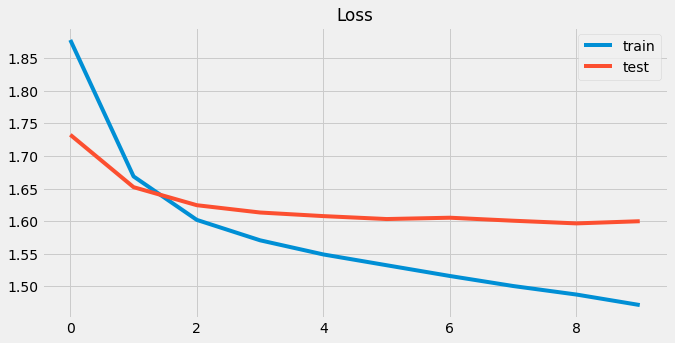

In [84]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

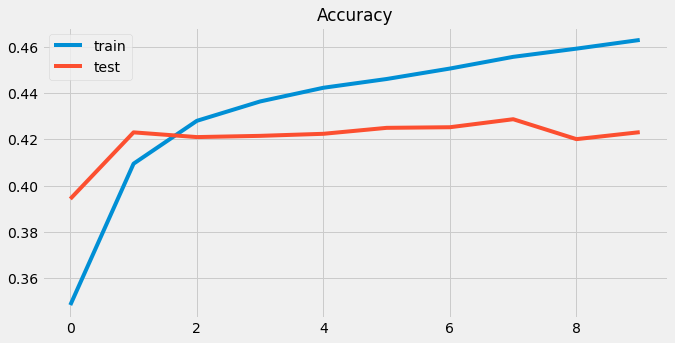

In [85]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [86]:
new_review = ['I have tried several different blood pressure meds. Valsartan gave me the worst side effects, dizziness, shakiness, nausea, headaches, sore muscles, and extreme fatigue! I would not recommend this drug to anyone. Actually raised my blood pressure.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(pred, labels[np.argmax(pred)])

[[0.6554184  0.15644214 0.08265819 0.04289234 0.03746995 0.00857768
  0.00434769 0.00329539 0.00268731 0.00621083]] 1


In [87]:
new_review2 = ['Works good on 160 mg. But I need to take bisoprolol for atrial fibrillation also.']
seq2 = tokenizer.texts_to_sequences(new_review2)
padded2 = pad_sequences(seq2, maxlen=MAX_SEQUENCE_LENGTH)
pred2 = model.predict(padded2)
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(pred2, labels[np.argmax(pred2)])

[[0.0061425  0.00472713 0.00553127 0.00788827 0.01556879 0.01887542
  0.04898277 0.1371631  0.26952553 0.48559517]] 10


In [88]:
# start with smaller size
# try decreasing learning rate, or adding dropout layer to avoid overfitting
# build confusion matrix for each class
# try add one more layer
# try add weight to deal with imbalanced data

In [90]:
y_pred = model.predict(X_test)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [103]:
y_pred_label = []
y_test_label = []
for i in range(len(y_pred)):
    y_pred_label.append(labels[np.argmax(y_pred[i])])
    y_test_label.append(labels[np.argmax(y_test[i])])

In [105]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [106]:
cm = confusion_matrix(y_test_label, y_pred_label)

<AxesSubplot:>

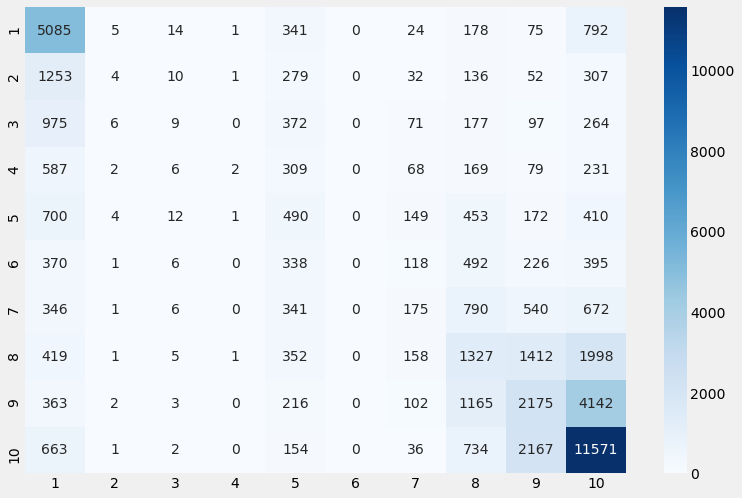

In [107]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index=[i for i in range(1,11)],columns = [i for i in range(1,11)])
plt.figure(figsize=(12,8))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [108]:
# test on unseen data
test = pd.read_csv("../data/drugsComTest_raw.tsv", delimiter='\t')
test = test.rename(columns = {"Unnamed: 0": "uniqueID"})
test['date'] = pd.to_datetime(test['date'])
test['review'] = test['review'].apply(clean_text)
X_unseen = tokenizer.texts_to_sequences(test['review'].values)
X_unseen = pad_sequences(X_unseen, maxlen=MAX_SEQUENCE_LENGTH)
y_unseen = pd.get_dummies(test['rating']).values
y_pred_unseen = model.predict(X_unseen)
accr = model.evaluate(X_unseen, y_unseen)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1681/1681 [==============================] - 139s 83ms/step - loss: 1.5960 - accuracy: 0.4309
Test set
  Loss: 1.596
  Accuracy: 0.431


In [111]:
y_pred_label1 = []
y_test_label1 = []
for i in range(len(y_pred_unseen)):
    y_pred_label1.append(labels[np.argmax(y_pred_unseen[i])])
    y_test_label1.append(labels[np.argmax(y_unseen[i])])
cm = confusion_matrix(y_test_label1, y_pred_label1)

<AxesSubplot:>

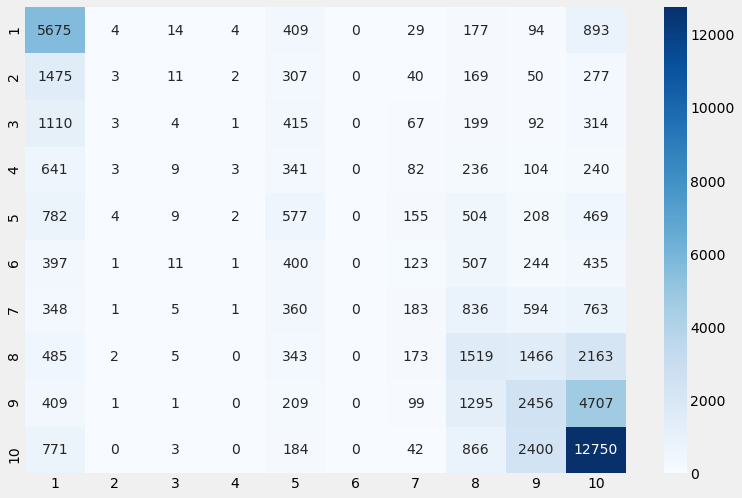

In [112]:
df_cm = pd.DataFrame(cm, index=[i for i in range(1,11)],columns = [i for i in range(1,11)])
plt.figure(figsize=(12,8))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')